<a href="https://colab.research.google.com/github/ak2449/SNN-Project/blob/main/SNN_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SNN Binary Classification


In [ ]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 5.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import functional as SF
import matplotlib.pyplot as plt
from snntorch import surrogate
import math, time
import torch, torch.nn as nn, torch.nn.functional as F


Data Generation


In [ ]:
# --- 1. Data Generation ---

# --- Parameters ---
c = 3e8
fc = 77e9
bw = 150e6
T_chirp = 10e-6
k = bw / T_chirp
fs = 2 * bw
t = np.arange(0, T_chirp, 1/fs)
n_samples = len(t)
tx_phase = 2 * np.pi * (fc * t + (k/2) * t**2)
Tx = np.exp(1j * tx_phase)

# --- Data simulation function ---
def generate_sample(batch_size):
    """
    Generates a batch of beat signals and corresponding labels.
    """
    # Create empty tensors to store the data
    # Shape: (batch_size, num_timesteps)
    data_tensor = torch.zeros((batch_size, n_samples))
    # Shape: (batch_size)
    label_tensor = torch.zeros((batch_size), dtype=torch.long)

    for i in range(batch_size):
        # Create a random target
        # 50% chance of "Near" (25-100m)
        # 50% chance of "Far" (125-200m)
        if np.random.rand() > 0.5:
            target_range = np.random.uniform(125, 200)
            label = 1  # "Far"
        else:
            target_range = np.random.uniform(25, 100)
            label = 0  # "Near"

        # --- Simulate the beat signal ---
        tau = (2 * target_range) / c
        t_rx = t - tau
        rx_phase = 2 * np.pi * (fc * t_rx + (k/2) * t_rx**2)
        Rx = np.exp(1j * rx_phase)
        Mix_signal = Tx * np.conj(Rx) # Simplified (no noise/atten)

        # Use the real part as the input signal
        real_signal = np.real(Mix_signal)

        # Store in tensors
        data_tensor[i] = torch.tensor(real_signal, dtype=torch.float)
        label_tensor[i] = torch.tensor(label, dtype=torch.long)

    # Reshape data for snntorch: (batch_size, num_timesteps, 1 input feature)
    data_tensor = data_tensor.unsqueeze(2)

    return data_tensor, label_tensor

Preprocessing Data

In [ ]:
# --- Preprocess: decimate + normalize (+ optional AWGN) ---
def preprocess_batch(x, decim=20, add_awgn=True, snr_db_range=(10, 25)):
    """
    x: [B, T, 1] float
    returns: [B, T', 1]
    """
    B, T, C = x.shape
    # [B, 1, T] for 1D ops
    x = x.permute(0, 2, 1)

    # simple average-pool decimation
    x = F.avg_pool1d(x, kernel_size=decim, stride=decim)  # [B,1,T']

    # per-sample normalization over time
    # mean = x.mean(dim=2, keepdim=True)
    # std = x.std(dim=2, keepdim=True).clamp_min(1e-6)
    # x = (x - mean) / std

    # optional light AWGN augmentation (train mode can toggle this)
    if add_awgn:
        B, C, Tp = x.shape
        # choose an SNR per sample
        snr_db = torch.empty(B, 1, 1, device=x.device).uniform_(*snr_db_range)
        snr = 10 ** (snr_db / 10)
        sig_pow = (x**2).mean(dim=2, keepdim=True)  # ~1 after norm, but compute anyway
        noise_pow = sig_pow / snr
        noise = torch.randn_like(x) * noise_pow.sqrt()
        x = x + noise

    # back to [B, T', 1]
    x = x.permute(0, 2, 1)
    return x

# Data Visualisation

<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:79: SyntaxWarning: invalid escape sequence '\m'
<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:79: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3815235048.py:55: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Time ($\mu s$)")
/tmp/ipython-input-3815235048.py:79: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Time ($\mu s$)")


Generated one 'Near' (Label 0) and one 'Far' (Label 1) sample.
Original 'Near' shape: torch.Size([1, 3000, 1])
Processed 'Near' shape: torch.Size([1, 37, 1])
Original 'Far' shape: torch.Size([1, 3000, 1])
Processed 'Far' shape: torch.Size([1, 37, 1])
Saved 'near_target_comparison.png'
Saved 'far_target_comparison.png'


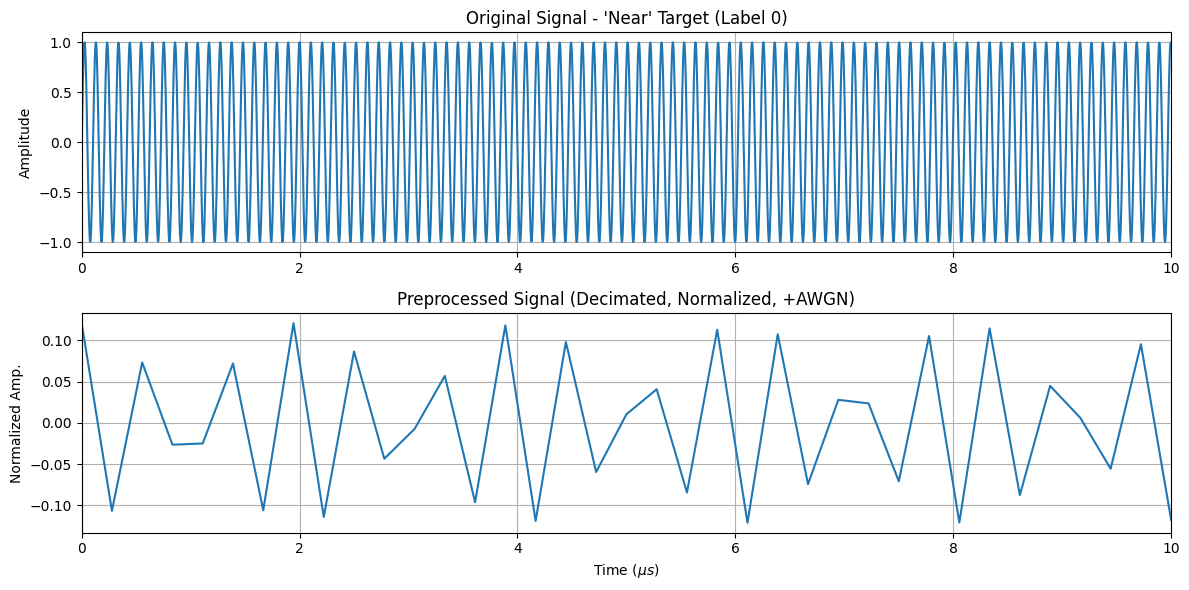

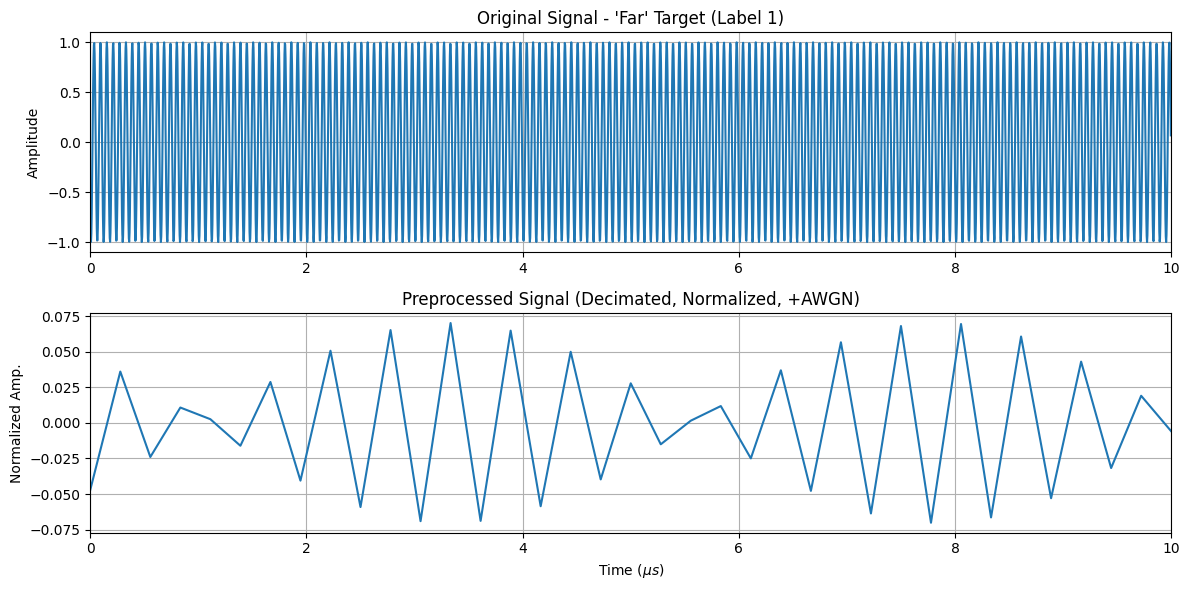

In [ ]:
# --- 4. Generation and Plotting Logic ---

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate one "Near" sample (Label 0)
data_near, label_near = generate_sample(1)
while label_near[0] != 0:
    data_near, label_near = generate_sample(1)

# Generate one "Far" sample (Label 1)
data_far, label_far = generate_sample(1)
while label_far[0] != 1:
    data_far, label_far = generate_sample(1)

print("Generated one 'Near' (Label 0) and one 'Far' (Label 1) sample.")

# Preprocess both samples
data_near_processed = preprocess_batch(data_near, add_awgn=False)
data_far_processed = preprocess_batch(data_far, add_awgn=False)

print(f"Original 'Near' shape: {data_near.shape}")
print(f"Processed 'Near' shape: {data_near_processed.shape}")
print(f"Original 'Far' shape: {data_far.shape}")
print(f"Processed 'Far' shape: {data_far_processed.shape}")

# --- Get data for plotting (convert from torch tensors to numpy) ---
original_near_signal = data_near[0, :, 0].numpy()
processed_near_signal = data_near_processed[0, :, 0].numpy()
original_far_signal = data_far[0, :, 0].numpy()
processed_far_signal = data_far_processed[0, :, 0].numpy()

# Create time axes
# 't' is already defined for the original signal
# We plot in microseconds (1e6) for readability
t_us = t * 1e6
t_processed_us = np.linspace(0, T_chirp * 1e6, processed_near_signal.shape[0])

# --- Plot 1: "Near" Target ---
plt.figure(figsize=(12, 6))

# Original
plt.subplot(2, 1, 1)
plt.plot(t_us, original_near_signal)
plt.title("Original Signal - 'Near' Target (Label 0)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.xlim(0, T_chirp * 1e6) # Ensure x-axis matches

# Preprocessed
plt.subplot(2, 1, 2)
plt.plot(t_processed_us, processed_near_signal)
plt.title("Preprocessed Signal (Decimated, Normalized, +AWGN)")
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Normalized Amp.")
plt.grid(True)
plt.xlim(0, T_chirp * 1e6) # Ensure x-axis matches

plt.tight_layout()
plt.savefig("near_target_comparison.png")
print("Saved 'near_target_comparison.png'")

# --- Plot 2: "Far" Target ---
plt.figure(figsize=(12, 6))

# Original
plt.subplot(2, 1, 1)
plt.plot(t_us, original_far_signal)
plt.title("Original Signal - 'Far' Target (Label 1)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.xlim(0, T_chirp * 1e6) # Ensure x-axis matches

# Preprocessed
plt.subplot(2, 1, 2)
plt.plot(t_processed_us, processed_far_signal)
plt.title("Preprocessed Signal (Decimated, Normalized, +AWGN)")
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Normalized Amp.")
plt.grid(True)
plt.xlim(0, T_chirp * 1e6) # Ensure x-axis matches

plt.tight_layout()
plt.savefig("far_target_comparison.png")
print("Saved 'far_target_comparison.png'")

torch.Size([2, 150, 1])
tensor(1)


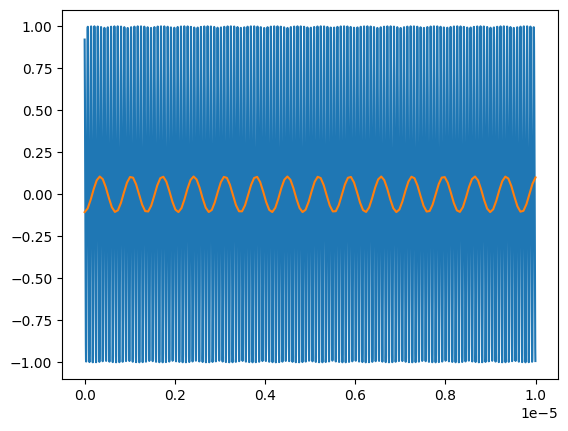

In [ ]:
batch_size = 2
# plt.figure(figsize=(12, 6))
data, targets = generate_sample(batch_size)
plt.plot(t,data[0])
pre_data = preprocess_batch(data, decim=20, add_awgn=False)
print(pre_data.shape)
t_processed = np.linspace(0, T_chirp, pre_data.shape[1])
plt.plot(t_processed,pre_data[0])
print(targets[0])



#SNN Code
This is a multi-layer model

Device: cuda
Training...
Epoch 01 | loss=0.6937 | mean_spike=0.000
Epoch 02 | loss=0.6807 | mean_spike=0.034
Epoch 03 | loss=0.6627 | mean_spike=0.072
Epoch 04 | loss=0.6457 | mean_spike=0.187
Epoch 05 | loss=0.6255 | mean_spike=0.275
Epoch 06 | loss=0.6029 | mean_spike=0.413
Epoch 07 | loss=0.5844 | mean_spike=0.457
Epoch 08 | loss=0.5600 | mean_spike=0.480
Epoch 09 | loss=0.5331 | mean_spike=0.497
Epoch 10 | loss=0.5139 | mean_spike=0.495
Epoch 11 | loss=0.5074 | mean_spike=0.495
Epoch 12 | loss=0.4956 | mean_spike=0.494
Epoch 13 | loss=0.4831 | mean_spike=0.495
Epoch 14 | loss=0.4823 | mean_spike=0.496
Epoch 15 | loss=0.4743 | mean_spike=0.497
Training complete.
Test accuracy: 86.04%

Generating loss plot...


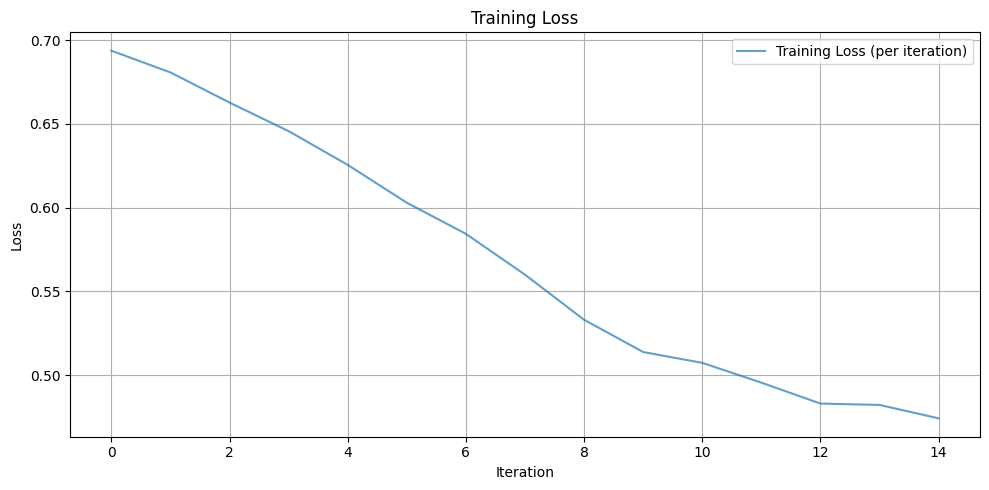

In [ ]:
#Use gpu if possible otherwise CPU is used
device = "cuda" if torch.cuda.is_available() else "cpu"

# Choose decimation to target ~150 steps from 3000
D = 20

# --- SNN model (time-major loop) ---
class BeatSNN(nn.Module):
    def __init__(self, in_dim=1, hidden=10, beta=0.95, threshold=0.75):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.lif1 = snn.Leaky(beta=beta, threshold=threshold,spike_grad=surrogate.fast_sigmoid())
        self.fc2 = nn.Linear(hidden, 2)
        self.lif2 = snn.Leaky(beta=beta, threshold=threshold,spike_grad=surrogate.fast_sigmoid())

        # Good inits
        nn.init.kaiming_normal_(self.fc1.weight); nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_normal_(self.fc2.weight); nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        """
        x: [B, T', 1]
        returns spk_out: [T', B, 2]
        """
        B, T, _ = x.shape
        # init states for this batch on the right device
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk_rec = []
        for t in range(T):
            h1 = self.fc1(x[:, t, :])
            s1, mem1 = self.lif1(h1, mem1)
            h2 = self.fc2(s1)
            s2, mem2 = self.lif2(h2, mem2)
            spk_rec.append(s2)
        return torch.stack(spk_rec, dim=0)  # [T', B, 2]

# --- Training setup ---
net = BeatSNN().to(device)
opt = torch.optim.Adam(net.parameters(), lr=2e-3)
loss_fn = SF.ce_rate_loss()
grad_clip = 1.0

num_epochs = 15
batches_per_epoch = 64
batch_size = 64

print(f"Device: {device}")
print("Training...")

loss_hist = []
for epoch in range(1, num_epochs + 1):
    net.train()
    running = 0.0

    for _ in range(batches_per_epoch):
        # 1) synth batch from your generator
        data, targets = generate_sample(batch_size)
        data = data.to(device)           # [B,T,1]
        targets = targets.to(device)
        # 2) preprocess
        data = preprocess_batch(data, decim=D, add_awgn=True)
        # 3) forward
        spk_rec = net(data)              # [T',B,2]
        # 4) loss
        loss = loss_fn(spk_rec, targets)
        running += loss.item()
        # 5) step
        opt.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), grad_clip)
        opt.step()

    avg = running / batches_per_epoch
    loss_hist.append(avg)

    # quick spike-rate sanity: mean spikes per time/neuron
    with torch.no_grad():
        spk_mean = spk_rec.float().mean().item()
    print(f"Epoch {epoch:02d} | loss={avg:.4f} | mean_spike={spk_mean:.3f}")

print("Training complete.")

# --- Eval ---
net.eval()
with torch.no_grad():
    test_data, test_targets = generate_sample(1024)
    test_data = test_data.to(device)
    test_targets = test_targets.to(device)

    test_data = preprocess_batch(test_data, decim=D, add_awgn=False)  # no noise in eval

    spk = net(test_data)                 # [T',B,2]
    rates = spk.sum(dim=0)               # [B,2]
    pred = rates.argmax(dim=1)
    acc = (pred == test_targets).float().mean().item()

print(f"Test accuracy: {acc*100:.2f}%")

print("\nGenerating loss plot...")
fig = plt.figure(figsize=(10, 5))

# Plot training loss (per iteration)
plt.plot(loss_hist, label="Training Loss (per iteration)", alpha=0.7)

# Calculate x-axis coordinates for test loss (at the end of each epoch)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Single Neuron Model

Device: cuda
Training...
Epoch 01 | loss=0.4292 | mean_spike=0.168
Epoch 02 | loss=0.3166 | mean_spike=0.340
Epoch 03 | loss=0.2581 | mean_spike=0.509
Epoch 04 | loss=0.2570 | mean_spike=0.625
Epoch 05 | loss=0.2699 | mean_spike=0.657
Epoch 06 | loss=0.2786 | mean_spike=0.673
Epoch 07 | loss=0.2810 | mean_spike=0.688
Epoch 08 | loss=0.2865 | mean_spike=0.679
Epoch 09 | loss=0.2855 | mean_spike=0.689
Epoch 10 | loss=0.2852 | mean_spike=0.707
Epoch 11 | loss=0.2895 | mean_spike=0.708
Epoch 12 | loss=0.2898 | mean_spike=0.711
Training complete.
Test accuracy: 49.12%

Generating loss plot...


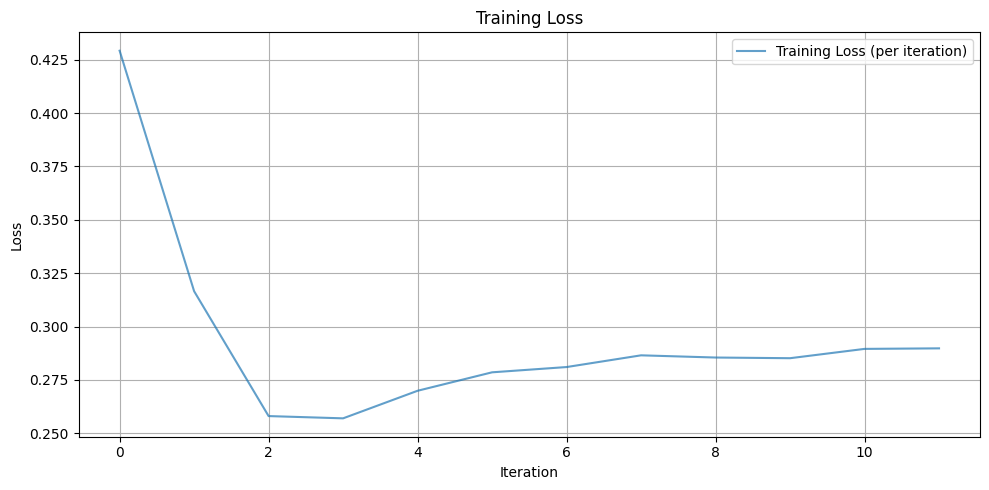

In [ ]:
#Use gpu if possible otherwise CPU is used
device = "cuda" if torch.cuda.is_available() else "cpu"

# Choose decimation to target ~150 steps from 3000
D = 20

# --- 3. SNN model (1 neuron, no hidden layer) ---
class SimpleSNN(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, beta=0.9999, threshold=0.75):
        super().__init__()
        # Direct input-to-output mapping
        self.fc_out = nn.Linear(in_dim, out_dim)
        self.lif_out = snn.Leaky(beta=beta, threshold=threshold,spike_grad=surrogate.fast_sigmoid())

        # Good inits
        nn.init.kaiming_normal_(self.fc_out.weight)
        nn.init.zeros_(self.fc_out.bias)

    def forward(self, x):
        """
        x: [B, T', 1]
        returns spk_out: [T', B, 1]
        """
        B, T, _ = x.shape
        # init output neuron state
        mem_out = self.lif_out.init_leaky()

        spk_rec = []
        for t in range(T):
            h_out = self.fc_out(x[:, t, :])
            s_out, mem_out = self.lif_out(h_out, mem_out)
            spk_rec.append(s_out)

        return torch.stack(spk_rec, dim=0)  # [T', B, 1]

## --- 4. Training setup ---
net = SimpleSNN().to(device)
opt = torch.optim.Adam(net.parameters(), lr=2e-3)

# **CRITICAL CHANGE**: Use mse_count_loss
# We want the correct class (1) to have a 100% rate
# and the incorrect class (0) to have a 0% rate.
loss_fn = nn.MSELoss()
grad_clip = 1.0

num_epochs = 12
batches_per_epoch = 64
batch_size = 64

print(f"Device: {device}")
print("Training...")

loss_hist = []
for epoch in range(1, num_epochs + 1):
    net.train()
    running = 0.0

    for _ in range(batches_per_epoch):
        # 1) synth batch
        data, targets = generate_sample(batch_size)
        data = data.to(device)

        # **NO CHANGE NEEDED HERE**:
        # Targets should be 0 or 1 (long/int)
        # The loss_fn handles mapping 0 to incorrect_rate and 1 to correct_rate
        targets = targets.to(device).float()

        # 2) preprocess
        data = preprocess_batch(data, decim=D, add_awgn=True)
        # 3) forward
        spk_rec = net(data)              # [T',B,1]

        rates = spk_rec.mean(dim=0)
        targets_float = targets.float().unsqueeze(1)
        # 4) loss
        loss = loss_fn(rates, targets_float)
        running += loss.item()
        # 5) step
        opt.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), grad_clip)
        opt.step()

    avg = running / batches_per_epoch
    loss_hist.append(avg)

    with torch.no_grad():
        spk_mean = spk_rec.float().mean().item()
    print(f"Epoch {epoch:02d} | loss={avg:.4f} | mean_spike={spk_mean:.3f}")

print("Training complete.")

# --- 5. Eval ---
net.eval()
with torch.no_grad():
    test_data, test_targets = generate_sample(1024)
    test_data = test_data.to(device)
    test_targets = test_targets.to(device)

    test_data = preprocess_batch(test_data, decim=D, add_awgn=False)
    spk = net(test_data)                 # [T',B,1]

    # **Prediction based on a 0.5 threshold**
    # Get the mean firing rate across all time steps
    rates = spk.mean(dim=0)              # [B,1] mean rate per step

    # Squeeze from [B, 1] to [B]
    # Predict 1 if rate > 0.5 (closer to 1.0 target), else 0
    pred = (rates.squeeze() > 0.5).long() # Use .long() to match target dtype

    # Compare predictions to the original 0/1 integer targets
    acc = (pred == test_targets).float().mean().item()

print(f"Test accuracy: {acc*100:.2f}%")

# --- 6. Plotting ---
print("\nGenerating loss plot...")
fig = plt.figure(figsize=(10, 5))
plt.plot(loss_hist, label="Training Loss (per iteration)", alpha=0.7)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Single Neuron with zero crossings encoded

Device: cuda
Training...
Epoch 01 | loss=0.4848 | mean_in_spk=0.441 | mean_out_spk=0.225
Epoch 02 | loss=0.4689 | mean_in_spk=0.549 | mean_out_spk=0.272
Epoch 03 | loss=0.4188 | mean_in_spk=0.470 | mean_out_spk=0.371
Epoch 04 | loss=0.3443 | mean_in_spk=0.548 | mean_out_spk=0.460
Epoch 05 | loss=0.2938 | mean_in_spk=0.502 | mean_out_spk=0.457
Epoch 06 | loss=0.2576 | mean_in_spk=0.513 | mean_out_spk=0.474
Epoch 07 | loss=0.2271 | mean_in_spk=0.551 | mean_out_spk=0.420
Epoch 08 | loss=0.2047 | mean_in_spk=0.571 | mean_out_spk=0.429
Epoch 09 | loss=0.1830 | mean_in_spk=0.530 | mean_out_spk=0.456
Epoch 10 | loss=0.1665 | mean_in_spk=0.462 | mean_out_spk=0.494
Epoch 11 | loss=0.1492 | mean_in_spk=0.501 | mean_out_spk=0.482
Epoch 12 | loss=0.1364 | mean_in_spk=0.507 | mean_out_spk=0.465
Epoch 13 | loss=0.1277 | mean_in_spk=0.514 | mean_out_spk=0.463
Epoch 14 | loss=0.1230 | mean_in_spk=0.555 | mean_out_spk=0.437
Epoch 15 | loss=0.1142 | mean_in_spk=0.466 | mean_out_spk=0.533
Training comple

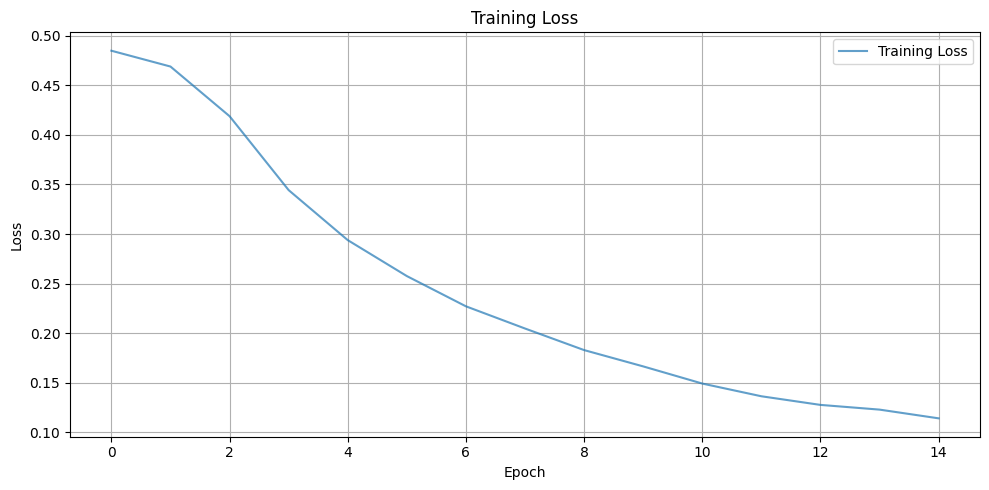

In [ ]:
# --- 2. NEW Pre-processing: Zero-Crossing Detector ---
def preprocess_batch_zero_crossing(x):
    """
    Converts a batch of waves [B, T, 1] into a batch of
    spike trains [B, T, 1] based on zero-crossings.
    """
    x = x.permute(0, 2, 1)
    # simple average-pool decimation
    x = F.avg_pool1d(x, kernel_size=20, stride=20)  # [B,1,T']
    # back to [B, T', 1]
    x = x.permute(0, 2, 1)

    # Get the sign of the current step
    sign_current = torch.sign(x)

    # Get the sign of the previous step (roll by 1 along time dim)
    sign_prev = torch.roll(sign_current, 1, dims=1)

    # Set the "previous" sign at t=0 to 0 (or any non -1/1)
    # This avoids a false crossing at the first step
    sign_prev[:, 0, :] = 0

    # A crossing happens where the sign changes (e.g., -1 to 1 or 1 to -1)
    spikes = (sign_current != sign_prev).float()

    return spikes

# --- 3. SNN model (1 neuron, no hidden layer) ---
class SimpleSNN(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, beta=0.95, threshold=0.75):
        super().__init__()
        self.fc_out = nn.Linear(in_dim, out_dim)
        self.lif_out = snn.Leaky(beta=beta, threshold=threshold,
                                 spike_grad=surrogate.fast_sigmoid())
        nn.init.kaiming_normal_(self.fc_out.weight)
        nn.init.zeros_(self.fc_out.bias)

    def forward(self, x):
        B, T, _ = x.shape
        mem_out = self.lif_out.init_leaky()
        spk_rec = []
        for t in range(T):
            h_out = self.fc_out(x[:, t, :])
            s_out, mem_out = self.lif_out(h_out, mem_out)
            spk_rec.append(s_out)
        return torch.stack(spk_rec, dim=0)

# --- 4. Training setup ---
device = "cuda" if torch.cuda.is_available() else "cpu"
net = SimpleSNN().to(device)
opt = torch.optim.Adam(net.parameters(), lr=2e-3)
loss_fn = nn.MSELoss() # Use MSE to train the rate
grad_clip = 1.0

num_epochs = 15 # May need a few more epochs
batches_per_epoch = 64
batch_size = 64

print(f"Device: {device}")
print("Training...")

loss_hist = []
for epoch in range(1, num_epochs + 1):
    net.train()
    running = 0.0

    for _ in range(batches_per_epoch):
        # 1) synth batch
        data, targets = generate_sample(batch_size)
        data = data.to(device)
        targets = targets.to(device)

        # 2) **CRITICAL CHANGE**: Use zero-crossing preprocess
        data = preprocess_batch_zero_crossing(data)

        # 3) forward
        spk_rec = net(data)              # [T',B,1]

        # 4) loss (Train rate towards 0.0 or 1.0)
        rates = spk_rec.mean(dim=0)      # [B, 1]
        targets_float = targets.float().unsqueeze(1)
        loss = loss_fn(rates, targets_float)
        running += loss.item()

        # 5) step
        opt.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), grad_clip)
        opt.step()

    avg = running / batches_per_epoch
    loss_hist.append(avg)

    with torch.no_grad():
        # 'data' here is the *spike train*
        input_spike_mean = data.float().mean().item()
        output_spike_mean = spk_rec.float().mean().item()
    print(f"Epoch {epoch:02d} | loss={avg:.4f} | mean_in_spk={input_spike_mean:.3f} | mean_out_spk={output_spike_mean:.3f}")

print("Training complete.")

# --- 5. Eval ---
net.eval()
with torch.no_grad():
    test_data, test_targets = generate_sample(1024)
    test_data = test_data.to(device)
    test_targets = test_targets.to(device)

    # **CRITICAL CHANGE**: Use zero-crossing preprocess
    test_data = preprocess_batch_zero_crossing(test_data)

    spk = net(test_data)                 # [T',B,1]

    # Prediction based on a 0.5 threshold
    rates = spk.mean(dim=0)              # [B,1]
    pred = (rates.squeeze() > 0.5).long()

    acc = (pred == test_targets).float().mean().item()

print(f"Test accuracy: {acc*100:.2f}%")

# --- 6. Plotting ---
print("\nGenerating loss plot...")
fig = plt.figure(figsize=(10, 5))
plt.plot(loss_hist, label="Training Loss", alpha=0.7)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()